In [1]:
#### IF you are using Google colab only then please do the following to make it easy to work in colab. 
# Uncomment and run cells in colab
#-----------------------------------------------------------------------------------------------

# 1. Mount ur google drive where the course folder is downloaded.
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# 2. Set the path to the course directory
# import os
# os.chdir('/content/drive/My Drive/Course-1-Deep-Learning-Mastery-Build-Your-AI-Foundation-main/Section11-DL-NLP-P3')
# print("Current Directory:", os.getcwd())

In [4]:
# 3. install the following libraries. u can install any other library also with !pip install "library"
# !pip install tensorflow numpy pandas matplotlib

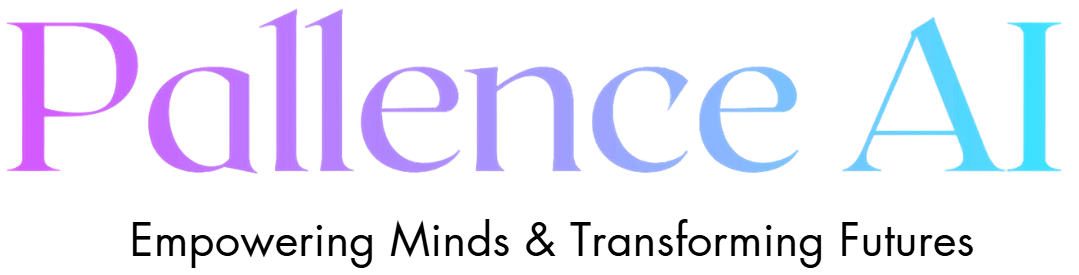

In [1]:
from IPython.display import Image, display
display(Image("./images/PallenceAI-Final.png", width=800))

# Text Generation Language Model: Sequence to Sequence 

## Transformers: Decoder Only

### Lets Build a Decoder only model on IMDB dataset for Text Generation

### Import needed libraries 

In [1]:
#Basic Python packages for data wrangling
import numpy as np
import pandas as pd
import random
import re
import string
import matplotlib.pyplot as plt

from pathlib import Path

#Tensorflow & Keras related packages
import tensorflow as tf
from tensorflow import keras
from keras import layers

from utils import plot_history

### Load the IMDB Dataset

In [ ]:
#import tensorflow_datasets as tfds

# train, val, test = tfds.load(
#     name="imdb_reviews",
#     split=["train[:80%]", "train[80%:]", "test"],
#     as_supervised=True)

In [2]:
import tensorflow_datasets as tfds

# Load all splits, including unsupervised
dataset_labeled = tfds.load(name="imdb_reviews", split="train+test", as_supervised=False)
dataset_unsupervised = tfds.load(name="imdb_reviews", split="unsupervised", as_supervised=False)

C:\Users\sridh\anaconda3\envs\tf2.10_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Understand & Preprocess the Data

In [3]:
dataset_labeled

<PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [4]:
# Extract only the 'text' feature from both splits
reviews_labeled = dataset_labeled.map(lambda x: x["text"])
reviews_unsupervised = dataset_unsupervised.map(lambda x: x["text"])

In [5]:
# Combine labeled and unsupervised reviews if desired
all_reviews = reviews_labeled.concatenate(reviews_unsupervised)

In [6]:
all_reviews

<ConcatenateDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [7]:
# Lets see how many total reviews we have
print (len(all_reviews))

100000


In [8]:
# Batch the data
imdb = all_reviews.batch(256)
imdb

<BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [9]:
imdb

<BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [10]:
# Lets take a peek at a sample review in the first batch
for reviews in imdb.take(1):
    print ("Reviews shape", reviews.shape)
    
    print ('First Review:', reviews[0].numpy().decode("utf-8"), "\n") 

Reviews shape (256,)
First Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it. 



**Vectorize the data**

In [11]:
# Define constants 
VOCAB_SIZE = 15000 # Max tokens
MAX_SEQ_LEN = 100 # Max sequence length
EMBED_DIM = 256 # Embedding dimension
HIDDEN_DIM = 2048 # Hidden dimension for dense layers
BATCH_SIZE= 256 # Batch size
NUM_HEADS = 2 # Number of heads for Multiheaded attention layer

In [12]:
# Define the vectorizer


def custom_standardization(input_string):
    # Convert to lowercase
    lowercase = tf.strings.lower(input_string)
    # Replace <br /> HTML tags with space
    no_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return no_html

vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    # we add an extra token since target will be offset by one token
    output_sequence_length=MAX_SEQ_LEN, 
    standardize=custom_standardization,
)

In [13]:
imdb

<BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [14]:
# Adapt the vectorizer to the dataset. Meaning creating the vocabulary 
vectorizer.adapt(imdb) 

In [15]:
vocab = vectorizer.get_vocabulary()
vocab

['',
 '[UNK]',
 'the',
 'a',
 'and',
 'of',
 'to',
 'is',
 'in',
 'i',
 'this',
 'it',
 'that',
 'was',
 'as',
 'with',
 'for',
 'but',
 'on',
 'movie',
 'are',
 'his',
 'not',
 'you',
 'film',
 'have',
 'be',
 'he',
 'one',
 'at',
 'by',
 'an',
 'they',
 'from',
 'all',
 'who',
 'like',
 'so',
 'just',
 'or',
 'has',
 "it's",
 'about',
 'if',
 'her',
 'some',
 'out',
 'what',
 'there',
 'when',
 'very',
 'more',
 'even',
 'would',
 'my',
 'good',
 'she',
 'their',
 'no',
 'only',
 'really',
 'up',
 'had',
 'can',
 'which',
 'see',
 'were',
 'than',
 'we',
 '-',
 'been',
 'into',
 'get',
 'will',
 'much',
 'because',
 'most',
 'story',
 'how',
 'other',
 'also',
 "don't",
 'first',
 'do',
 'its',
 'great',
 'time',
 'make',
 'me',
 'people',
 'could',
 'any',
 'after',
 'then',
 'bad',
 'made',
 'think',
 'being',
 'many',
 'it.',
 'never',
 'him',
 'two',
 'movie.',
 'where',
 'too',
 'little',
 'well',
 'watch',
 'way',
 'your',
 'them',
 'did',
 'does',
 'best',
 'characters',
 'lov

In [16]:
vocab_index = {i:word for i,word in enumerate(vocab)}
vocab_index

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'a',
 4: 'and',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'in',
 9: 'i',
 10: 'this',
 11: 'it',
 12: 'that',
 13: 'was',
 14: 'as',
 15: 'with',
 16: 'for',
 17: 'but',
 18: 'on',
 19: 'movie',
 20: 'are',
 21: 'his',
 22: 'not',
 23: 'you',
 24: 'film',
 25: 'have',
 26: 'be',
 27: 'he',
 28: 'one',
 29: 'at',
 30: 'by',
 31: 'an',
 32: 'they',
 33: 'from',
 34: 'all',
 35: 'who',
 36: 'like',
 37: 'so',
 38: 'just',
 39: 'or',
 40: 'has',
 41: "it's",
 42: 'about',
 43: 'if',
 44: 'her',
 45: 'some',
 46: 'out',
 47: 'what',
 48: 'there',
 49: 'when',
 50: 'very',
 51: 'more',
 52: 'even',
 53: 'would',
 54: 'my',
 55: 'good',
 56: 'she',
 57: 'their',
 58: 'no',
 59: 'only',
 60: 'really',
 61: 'up',
 62: 'had',
 63: 'can',
 64: 'which',
 65: 'see',
 66: 'were',
 67: 'than',
 68: 'we',
 69: '-',
 70: 'been',
 71: 'into',
 72: 'get',
 73: 'will',
 74: 'much',
 75: 'because',
 76: 'most',
 77: 'story',
 78: 'how',
 79: 'other',
 80: 'also',
 81: "don't",
 

In [17]:
# Vectorize the dataset
# Inputs: Each sequence except the last token
# Targets: Same sequence offset by one token

def vectorize_dataset(batch_reviews):
    vectorized_reviews = vectorizer(batch_reviews)
    inputs = vectorized_reviews[:,:-1] # inputs are created by removing last token
    targets = vectorized_reviews[:, 1:] # targets are created by offsetting by one token
    return inputs, targets

vectorized_imdb = imdb.map(vectorize_dataset, num_parallel_calls=4)

In [18]:
# Display a sample
for inputs, targets in vectorized_imdb.take(1):
    print(f"Inputs shape: {inputs.shape}")
    print(f"Targets shape: {targets.shape}")

Inputs shape: (256, 99)
Targets shape: (256, 99)


In [19]:
# Display a sample
for inputs, targets in vectorized_imdb.take(1):
    print(f"Inputs: {inputs[0]}")
    print(f"Targets: {targets[0]}")
    
# As you see inputs is nothing but the actual sequence except the last token
# targets is also the same sequence but offset by one token and 

Inputs: [   10    13    31   366   490   103    81    26 12813     8    30  1604
  6141    39   511     1   182    20    85  1096    17    10   197   291
    26    57   239   258     8  1821    52    57    85   131    90    22
  6042    10  1232   836  3796    10    19     7    31   367     1   190
  3026  4998     2    76  1558   153    66   132    49     2     1 10442
    66   242    57  4453    16     1  3630     1     1  1587     1     4
    44     1  2033    15  6141    13   161    17     3  1558   879 12896
     8     3    19    12    13  3923     5    91   146  7622     9   219
  1038    12    48]
Targets: [   13    31   366   490   103    81    26 12813     8    30  1604  6141
    39   511     1   182    20    85  1096    17    10   197   291    26
    57   239   258     8  1821    52    57    85   131    90    22  6042
    10  1232   836  3796    10    19     7    31   367     1   190  3026
  4998     2    76  1558   153    66   132    49     2     1 10442    66
   242    57  

### Build a Transformer based decoder only model

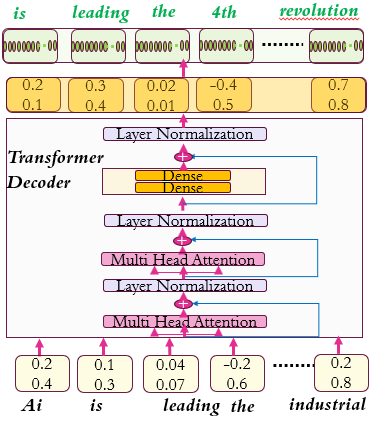

In [3]:
display(Image("./images/decoder_only2.png", width=500))

In [20]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#### Embeddings class

In [23]:
class CombinedEmbedding(layers.Layer):
    def __init__(self, MAX_SEQ_LEN, VOCAB_SIZE, EMBED_DIM, **kwargs):
        super().__init__(**kwargs)
        
        self.token_embeddings = layers.Embedding(input_dim = VOCAB_SIZE, output_dim=EMBED_DIM, 
                                                 mask_zero=True) # input embedding layer
        
        self.position_embeddings = layers.Embedding(input_dim = MAX_SEQ_LEN, 
                                                    output_dim = EMBED_DIM) # position embedding layer
        # both the above embeddings are initialized randomly first 
        #....and will be calculated as part of training process.
        
        self.sequence_length = MAX_SEQ_LEN
        self.max_tokens = VOCAB_SIZE
        self.embed_dim = EMBED_DIM

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        # Word or token embeddings
        embedded_tokens = self.token_embeddings(inputs)
        
        # Positional Embeddings
        embedded_positions = self.position_embeddings(positions)
        
        return embedded_tokens + embedded_positions # Return combined embeddings

    def compute_mask(self, inputs, mask=None):
        return self.token_embeddings.compute_mask(inputs, mask)
    # The compute_mask method in a custom layer ensures that the masking information 
    #...is correctly propagated through the layers.
    # without this the mask may not be propagated properly through the sebsequent layers.

    # whenever we use custom layers, mainly for saving and loading the model
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "sequence_length": self.sequence_length,
            "max_tokens": self.max_tokens,
        })
        return config

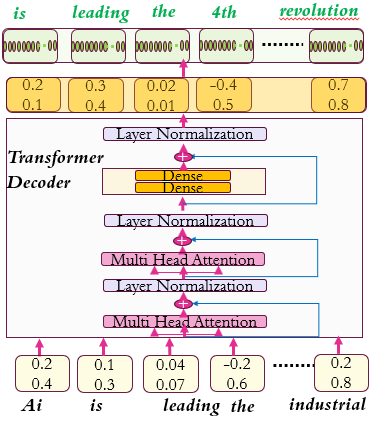

In [4]:
display(Image("./images/decoder_only2.png", width=500))

#### Transformer Decoder class

In [24]:
class TransformerDecoder(layers.Layer):
    def __init__(self, EMBED_DIM, NUM_HEADS, HIDDEN_DIM, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = EMBED_DIM
        self.num_heads = NUM_HEADS
        self.ff_dim = HIDDEN_DIM
        
        #Attention Layers
        self.attention1 = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)
        self.attention2 = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)
        
        #Feedforward Dense Layer
        self.ffn = keras.Sequential([
            layers.Dense(HIDDEN_DIM, activation="relu"),
            layers.Dense(EMBED_DIM),])
        
        #Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.supports_masking=True
        

    # Causal mask for the Decoder Inputs. because we dont want attention on future tokens
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

# 1 0 0 0 0
# 1 1 0 0 0
# 1 1 1 0 0
# 1 1 1 1 0
# 1 1 1 1 1

    # Main computation inside the call method
    def call(self, inputs, encoder_outputs, mask=None):
        
        # Causal mask for decoder inputs: self attention
        causal_mask = self.get_causal_attention_mask(inputs)
        
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask) # combined both masks
        else:
            padding_mask = mask
            
        # Self Attention for Decoder inputs
        attention_output1 = self.attention1(query=inputs,
                                            value=inputs,
                                            key=inputs,
                                            attention_mask=causal_mask)
        out1 = self.layernorm1(inputs + attention_output1)
        
        # 2nd attention layer
        attention_output2 = self.attention2(query=out1,
                                            value=encoder_outputs,
                                            key=encoder_outputs,
                                            attention_mask=causal_mask)
        out2 = self.layernorm2(out1 + attention_output2)
        
        # Feed forward dense layers
        ffn_output = self.ffn(out2)
        
        out3 = self.layernorm3(out2 + ffn_output)
        
        return out3

    #for loading the saved model, with custom layers.    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
        })
        return config

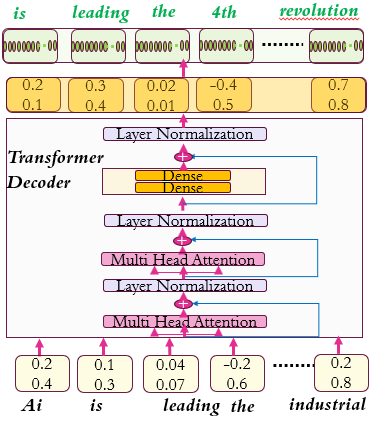

In [7]:
display(Image("./images/decoder_only2.png", width=500))

**Decoder Only Model**

In [25]:
# Build the decoder now

# Inputs
inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")

# Embedding layer (combined word embeddings + positional embeddings)
x = CombinedEmbedding(MAX_SEQ_LEN, VOCAB_SIZE, EMBED_DIM)(inputs)

# Transformer Decoder Block
x = TransformerDecoder(EMBED_DIM, NUM_HEADS, HIDDEN_DIM)(x,x)

# Dropout Layer
x = layers.Dropout(0.4)(x)

# Final dense layer mapping probability distribution over spanish vocabulary
outputs= layers.Dense(VOCAB_SIZE, activation="softmax")(x) 

In [26]:
model_decoderonly = keras.Model(inputs,outputs)
model_decoderonly.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 combined_embedding (CombinedEm  (None, None, 256)   3865600     ['decoder_inputs[0][0]']         
 bedding)                                                                                         
                                                                                                  
 transformer_decoder (Transform  (None, None, 256)   2104576     ['combined_embedding[0][0]',     
 erDecoder)                                                       'combined_embedding[0][0]']     
                                                                                              

### Compile & Train the Model

In [27]:
path = Path("./models/model_textgen.keras")

In [28]:
# We will reuse this function to train and evaluate for convenience
def train(model,path,data):
    
    #call backs
   
    earlystop_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    callbacks = [earlystop_cb]

    #Compile the model
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
    
    #Train the model
    history = model.fit(data, callbacks = callbacks, epochs=200)
    
    return history

In [29]:
history = train(model_decoderonly,path,vectorized_imdb)

Epoch 1/200
391/391 [==============================] - 83s 196ms/step - loss: 5.3244
Epoch 2/200
391/391 [==============================] - 75s 191ms/step - loss: 4.9009
Epoch 3/200
391/391 [==============================] - 75s 191ms/step - loss: 4.7199
Epoch 4/200
391/391 [==============================] - 72s 185ms/step - loss: 4.6265
Epoch 5/200
391/391 [==============================] - 77s 198ms/step - loss: 4.5645
Epoch 6/200
391/391 [==============================] - 78s 199ms/step - loss: 4.5204
Epoch 7/200
391/391 [==============================] - 78s 199ms/step - loss: 4.4840
Epoch 8/200
391/391 [==============================] - 78s 200ms/step - loss: 4.4547
Epoch 9/200
391/391 [==============================] - 79s 200ms/step - loss: 4.4288
Epoch 10/200
391/391 [==============================] - 79s 201ms/step - loss: 4.4050
Epoch 11/200
391/391 [==============================] - 80s 205ms/step - loss: 4.3854
Epoch 12/200
391/391 [==============================] - 76s 193

391/391 [==============================] - 74s 190ms/step - loss: 3.9358
Epoch 191/200
391/391 [==============================] - 74s 189ms/step - loss: 3.9355
Epoch 192/200
391/391 [==============================] - 74s 190ms/step - loss: 3.9353
Epoch 193/200
391/391 [==============================] - 74s 190ms/step - loss: 3.9347
Epoch 194/200
391/391 [==============================] - 74s 190ms/step - loss: 3.9342
Epoch 195/200
391/391 [==============================] - 74s 190ms/step - loss: 3.9340
Epoch 196/200
391/391 [==============================] - 74s 188ms/step - loss: 3.9334
Epoch 197/200
391/391 [==============================] - 74s 189ms/step - loss: 3.9327
Epoch 198/200
391/391 [==============================] - 74s 189ms/step - loss: 3.9322
Epoch 199/200
391/391 [==============================] - 74s 190ms/step - loss: 3.9321
Epoch 200/200
391/391 [==============================] - 74s 188ms/step - loss: 3.9318


### Inference: Generate new Text

In [41]:
# Function for sampling strategy
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions + 1e-10) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas) # returns the index with highest score after sampling

# Text Generation Function
def generate_text(prompt, model, text_vectorization, vocab_index, length, temperature=1.0):
    tokenized_prompt = text_vectorization([prompt])[0].numpy() # Vectorize the prompt
    generated_tokens = list(tokenized_prompt) # convert tokenized prompt to a list
    generated_text = prompt

    for _ in range(length):
        predictions = model(tf.expand_dims(generated_tokens, axis=0)) # call the model on the tokenized prompt
        next_token_probs = predictions[:, -1, :][0].numpy() # get the model predictions for the last token only
        next_token_index = sample_next(next_token_probs, temperature) #apply sampling strategy on the probabilities predicted by model
        sampled_word = vocab_index[next_token_index] # look up the actual predicted word based on the token index
        generated_text += " " + sampled_word # Append the predicted word to generated text
        generated_tokens.append(next_token_index) # append the predicted token index back to generated tokens and continue predicting
    return generated_text

In [45]:
# Example: Generate text
prompt = "Scarface"
generated_text = generate_text(
    prompt=prompt, # user prompt
    model=model_decoderonly, # model
    text_vectorization=vectorizer, # vectorizer used for preprocessing
    vocab_index={i: word for i, word in enumerate(vectorizer.get_vocabulary())}, # vocabuylary index
    length=50,  # Number of tokens to generate
    temperature=0.8  # Adjust temperature as needed
)

print("Generated Text:")
print(generated_text)

Generated Text:
Scarface mixing the conspiracy that sort of scientists in experiments directed by [UNK] nuclear [UNK] scientists inside fighting the orphanage the [UNK] dna [UNK] creature brain green and what happens to the vampire [UNK] is [UNK] who [UNK] could you expect from the curse in [UNK] there's something that will [UNK]


# !!!!! Congratualtions you have built your own Language Model :)

In [ ]:
# Our toy language model uses the same core technology as the GPT 1 model and also even the latest LLM's 

**GPT1 (2017) from OpenAI**

**!!! 110 Million Parameters**

* decoder blocks: 12

* Embedding dim: 768

* Hidden layer dim: 3072

* Attention Heads: 12

* Sequence Length: 512

* Vocab Size: 40000

* Training Data: BooksCorpus of 7000 books, 4.5 gb of text
